In [15]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lvm_to_h5 import *
from data_utils import import_lvm_file

## Importing Data

## Define Data Folders

In [16]:
# User Selection

Dropbox_drive = "F:/"
station_selected = "Station 3/"
NI_test_name = "st_1_test___002"


# Derived data paths
parent_data_folder = Dropbox_drive + "Dropbox/Projects/001 - CNRL - Pipewise/005 - Field Test/2023/data"
NI_raw_data_folder = parent_data_folder + "/NI/Raw Data/"

NI_converted_data_folder = parent_data_folder + "/NI/Converted Data/"

full_raw_path = NI_raw_data_folder + station_selected + NI_test_name + ".lvm"
full_converted_path = NI_converted_data_folder + station_selected + NI_test_name + ".h5"

# Full raw path (hardcoded)
full_raw_path = "F:/Dropbox/Projects/Field Test Data/CNRL - Test/Station 2/TEAC/LX20_001"
full_raw_path = "F:/Dropbox/Projects/Field Test Data/CNRL - Test/Station 1/TEAC/LX10_001"



### Deprecated - Directly importing from .lvm

In [17]:
# Useful, but takes a long time to load each file.
# 1.9GB file: 4m 20s. Optimized: 36.8 s
# 380MB file: 0m 41s. Optimized: 7.8 s
data_frame = import_lvm_file(full_raw_path)

FileNotFoundError: [Errno 2] No such file or directory: 'F:/Dropbox/Projects/Field Test Data/CNRL - Test/Station 1/TEAC/LX10_001'

### Preferred: Importing hdf5 file

In [28]:
#convert_lvm_to_hdf5(full_raw_path, full_converted_path)
#full_converted_path = "F:/Dropbox/Projects/001 - CNRL - Pipewise/005 - Field Test/2023/data/NI/Converted Data/Station 2/st_2_test___007.h5"
# Importing
#data_frame = read_h5_to_dataframe(full_converted_path)

## Header

In [5]:
print(data_frame.head())

    X_Value  D1 - Channel 0  D1 - Channel 1  D1 - Channel 2  D2 - Channel 0   
0  0.000000        0.004752        0.534248        0.726585        0.123214  \
1  0.000098        0.085517        0.563241        0.611017        0.203593   
2  0.000195        0.024790        0.413986        1.397535        0.246496   
3  0.000293        0.089133        0.427586        1.333274        0.301712   
4  0.000391        0.054069        0.286573        0.905894        0.304015   

   D2 - Channel 1  D2 - Channel 2  D1 - Channel 3  D2 - Channel 3   
0        0.203100       -0.015825        1.693741       -0.001073  \
1        0.147430       -0.036959        1.563109       -0.001048   
2        0.130422       -0.049361        0.856844       -0.001054   
3        0.076758       -0.114599       -0.099260       -0.001111   
4        0.023779       -0.127306       -1.044205       -0.001009   

   D3 - Channel 0  D3 - Channel 1  D3 - Channel 2  D4 - Temperature  
0       -0.000635       -0.000255       

## Meta Validation

### Data Points & Recording Time

In [12]:
# Access the first column using its index and count the number of data points
time_values = data_frame.iloc[:, 0]
data_points_count = time_values.count()

# Workaround to account for files that don't start at 0 seconds
initial_recording_time = time_values.iloc[0]
final_recording_time = time_values.iloc[-1]
delta_recording_time = final_recording_time - initial_recording_time

print("Number of data points in the first column:", data_points_count)
print("Data was recorded for", round(delta_recording_time,2), "seconds")
print("Data was recorded for", round(delta_recording_time/60,2), "minutes")
print("Data was recorded for", round(delta_recording_time/3600,2), "hours")

Number of data points in the first column: 6460000
Data was recorded for 630.86 seconds
Data was recorded for 10.51 minutes
Data was recorded for 0.18 hours


In [45]:
data_frame.iloc[-1, 0]/(60*60)

3.679470458888889

### Sampling rate, Consistency and CV

In [31]:
# Calculate the time differences between consecutive data points
time_differences = time_values.diff().dropna()

# Define the expected sampling rate (in Hz) and maximum allowed deviation (in percentage)
expected_sampling_rate = 10000  # Replace with your expected sampling rate
max_allowed_deviation = 0.05  # 5% deviation, for example

# Calculate the expected time difference between consecutive data points
expected_time_difference = 1 / expected_sampling_rate

# Calculate the deviation of each time difference from the expected time difference
deviation = np.abs(time_differences - expected_time_difference)

# Count the number of time intervals that exceed the maximum allowed deviation
exceed_threshold_count = np.sum(deviation > max_allowed_deviation * expected_time_difference)

# Calculate the percentage of time intervals that exceed the maximum allowed deviation
exceed_threshold_percentage = exceed_threshold_count / len(time_differences) * 100

# Calculate the effective sampling rate
effective_sampling_rate = 1 / time_differences.mean()

print(f"Expected sampling rate: {expected_sampling_rate} Hz")
print(f"Effective sampling rate: {effective_sampling_rate:.2f} Hz")
print(f"Number of time intervals exceeding {max_allowed_deviation * 100}% deviation: {exceed_threshold_count}")
print(f"Percentage of time intervals exceeding {max_allowed_deviation * 100}% deviation: {exceed_threshold_percentage:.2f}%")


Expected sampling rate: 10000 Hz
Effective sampling rate: 10240.00 Hz
Number of time intervals exceeding 5.0% deviation: 0
Percentage of time intervals exceeding 5.0% deviation: 0.00%


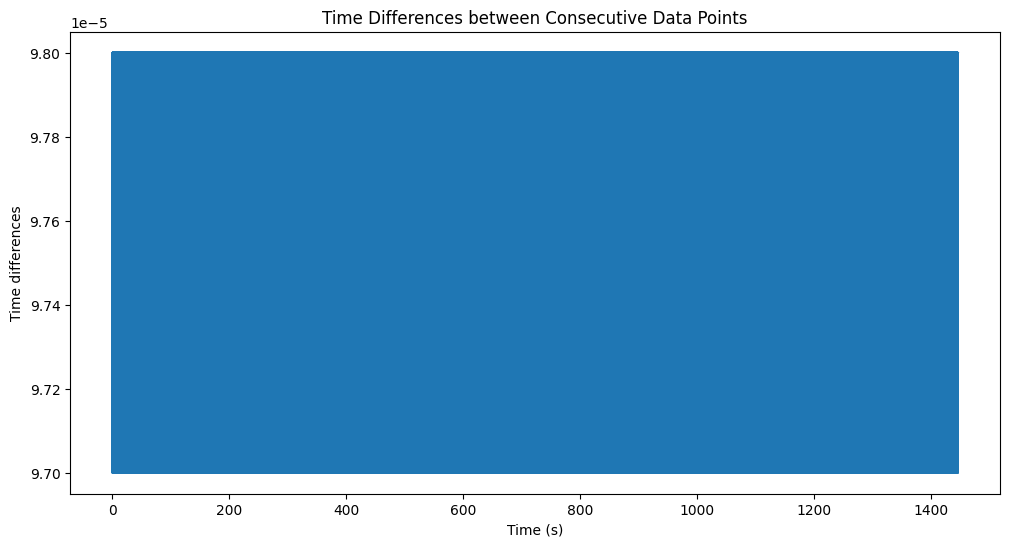

In [32]:
import matplotlib.pyplot as plt

# Remove the first value from time_values to match the length of time_differences
adjusted_time_values = time_values.iloc[1:]

plt.figure(figsize=(12, 6))
plt.plot(adjusted_time_values, time_differences)
plt.xlabel("Time (s)")
plt.ylabel("Time differences")
plt.title("Time Differences between Consecutive Data Points")
plt.show()

### Disk Space Required

In [33]:
# Calculate the duration in seconds
start_time = data_frame.iloc[0, 0]
end_time = data_frame.iloc[-1, 0]
duration_seconds = end_time - start_time

# Get the file size in bytes
file_size_bytes = os.path.getsize(full_raw_path)

# Convert file size to megabytes
file_size_mb = file_size_bytes / (1024 * 1024)

# Calculate disk space per second in megabytes
disk_space_per_second_mb = file_size_mb / duration_seconds

print(f"Disk space per second: {round(disk_space_per_second_mb,2)} MB/s")

print(f"Disk space per minute: {round(disk_space_per_second_mb*60,2)} MB/min")

print(f"Disk space per hour: {round(disk_space_per_second_mb*60*60/1024,2)} GB/hour")

Disk space per second: 1.28 MB/s
Disk space per minute: 76.98 MB/min
Disk space per hour: 4.51 GB/hour


In [34]:
# Apply the condition to all channels except for the first one (time_values)
# If a value is greater than 5 or less than -5, set it to zero
#data_frame.iloc[:, 1:] = data_frame.iloc[:, 1:].applymap(lambda x: 0 if x > 5 or x < -5 else x)

## Signal

### Device 1

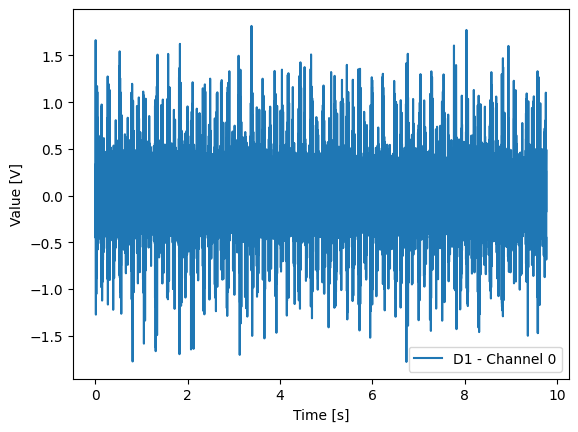

In [9]:
def plot_data(column_name="D1 - Channel 0", start_index=None, end_index=None):
    # Default to using all data if start_index or end_index aren't specified
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(data_frame)

    time_values = data_frame.iloc[start_index:end_index+1, 0]
    device_data = data_frame.loc[start_index:end_index, [column_name]]

    # Plot the column with time_values as the x-axis
    for column in device_data.columns:
        plt.plot(time_values, device_data[column], label=column)

    # Customize the plot
    plt.xlabel('Time [s]')
    plt.ylabel('Value [V]')
    plt.legend(device_data.columns, loc='best')

    # Show the plot
    plt.show()

# Call function with column name and start and end indices
plot_data("D1 - Channel 0", 0, 100000)


In [35]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["D1 - Channel 0", "D1 - Channel 1", "D1 - Channel 2"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(time_values, device_data[column], label=column)

#plt.xlim((16550, 16550.1))
#plt.ylim((-10, 11))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
plt.title('D1 Ch 0 - 2')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()


KeyboardInterrupt: 

### Device 2

In [ ]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["D2 - Channel 0", "D2 - Channel 1", "D2 - Channel 2"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(time_values, device_data[column], label=column)

#plt.xlim((-10, 11))
#plt.ylim((-10, 11))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
plt.title('D2 Ch 0 - 2')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()


KeyError: "None of [Index(['D2 - Channel 0', 'D2 - Channel 1', 'D2 - Channel 2'], dtype='object')] are in the [columns]"

### IRIG-B

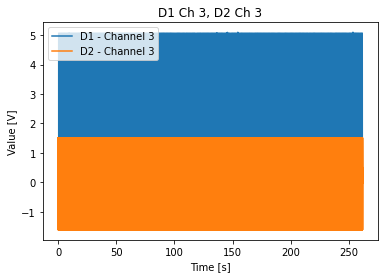

In [ ]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["D1 - Channel 3", "D2 - Channel 3"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(time_values, device_data[column], label=column)

#plt.xlim((10, 11))
#plt.ylim((-10, 11))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
plt.title('D1 Ch 3, D2 Ch 3')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()


## Device 3

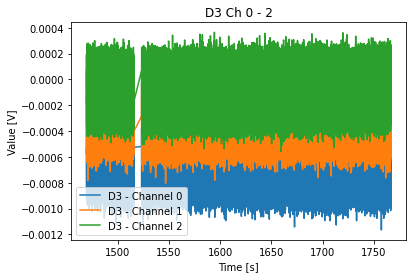

In [ ]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["D3 - Channel 0", "D3 - Channel 1", "D3 - Channel 2"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(time_values, device_data[column], label=column)

#plt.xlim((35, 40))
#plt.ylim((-2, 2))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
plt.title('D3 Ch 0 - 2')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()


## Device 4

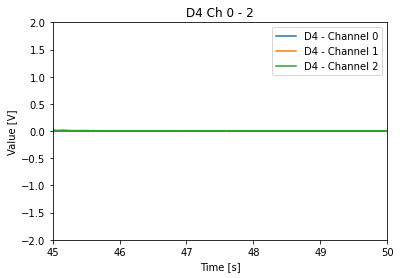

In [ ]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["D4 - Channel 0", "D4 - Channel 1", "D4 - Channel 2"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(time_values, device_data[column], label=column)

plt.xlim((45, 50))
plt.ylim((-2, 2))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
plt.title('D4 Ch 0 - 2')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()

In [ ]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["D4 - Temperature"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(time_values, device_data[column], label=column)

#plt.xlim((45, 50))
#plt.ylim((-2, 2))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
plt.title('D4')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()